# "Web Scrapping Popular Youtube Tech Channels with Selenium"
> "Data Mining, Data Wrangling, Data Exploratory Analysis"

- toc: false
- badges: true
- comments: true
- categories: [Selenium, Web Scrapping, Pandas, Youtube, Python]
- image: "images/thumbnails/header_youtube_web.png"

Notebook Created by: __David Rusho__ ([Github Blog](https://drusho.github.io/blog) | [Tableau](https://public.tableau.com/app/profile/drusho/) | [Linkedin](https://linkedin.com/in/davidrusho))

## About the Data

Web scraping was performed on the _Top 10 Tech Channels_ on Youtube using _[Selenium](https://selenium-python.readthedocs.io/)_ (an automated browser (driver) controlled using python, which is often used in web scraping and web testing).  These channels were selected using a __[Top 10 Tech Youtubers](https://blog.bit.ai/top-tech-youtubers/)__ list from blog.bit.ai.  

Data from 2,000 videos was scrapped, which equals about 200 of most popular videos per channel.

## Introduction

## Collecting and Cleaning Data


### Web Scrapping Youtube Channels

In [ ]:
#collapse

import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# Chrome driver location (for M1 macbook air)
DRIVER_PATH = "/opt/homebrew/bin/chromedriver"

# activate driver
driver = webdriver.Chrome(executable_path=DRIVER_PATH)


# Scroll to bottom of page
def scroll_page():
    for x in range(7):
        html = driver.find_element_by_tag_name("html")
        html.send_keys(Keys.END)
        time.sleep(2)


def scrap_videos():
    scroll_page()

    chan_xpath = '//*[@id="channel-name"]'
    subs_xpath = '//*[@id="subscriber-count"]'
    videos_class = "style-scope ytd-grid-video-renderer"
    views_xpath = './/*[@id="metadata-line"]/span[1]'
    post_date_xpath = './/*[@id="metadata-line"]/span[2]'

    title_xpath = './/*[@id="video-title"]'

    # Scrap Channel Name
    try:
        channel_name = driver.find_element_by_xpath(chan_xpath).text
    except (Exception,):
        pass

    # Scrap Number of Subscribers
    try:
        subscribers = driver.find_element_by_xpath(subs_xpath).text
    except (Exception,):
        pass

    # Reassign variable to recalculate all videos
    videos = driver.find_elements_by_class_name(videos_class)

    # Loop through all videos
    for video in videos:

        # grab title if available
        try:
            title = video.find_element_by_xpath(title_xpath).text
        except (Exception,):
            pass

        # grab url if available
        try:
            url = video.find_element_by_xpath(title_xpath).get_attribute("href")
        except (Exception,):
            pass

        # grab views if available
        try:
            views = video.find_element_by_xpath(views_xpath).text
        except (Exception,):
            pass

        # grab post date if available
        try:
            post_date = video.find_element_by_xpath(post_date_xpath).text
        except (Exception,):
            pass

        video_items = {
            "channel_name": channel_name,
            "subscribers": subscribers,
            "title": title,
            "views": views,
            "post_date": post_date,
            "url": url,
        }

        vid_list.append(video_items)

    return vid_list


# scrap Channel About section
def scrap_about():

    chan_name_xp = '//*[@id="channel-name"]'
    chan_join = './/*[@id="right-column"]/yt-formatted-string[2]/span[2]'
    chan_views = './/*[@id="right-column"]/yt-formatted-string[3]'
    chan_desc = './/*[@id="description"]'

    # Scrap Channel Name
    try:
        channel_name = driver.find_element_by_xpath(chan_name_xp).text
    except (Exception,):
        pass

    # Scrap Channel Join Date (about)
    try:
        channel_join = driver.find_element_by_xpath(chan_join).text
    except (Exception,):
        pass

    # Scrap Channel Views (about)
    try:
        channel_views = driver.find_element_by_xpath(chan_views).text
    except (Exception,):
        pass

    # Scrap Channel Description (about)
    try:
        channel_description = driver.find_element_by_xpath(chan_desc).text
    except (Exception,):
        pass

    about_items = {
        "channel_name": channel_name,
        "channel_join_date": channel_join,
        "channel_views": channel_views,
        "channel_description": channel_description,
    }

    vid_list.append(about_items)
    return vid_list


# top youtubers based off 'https://blog.bit.ai'
top_youtubers = [
    "ijustine",
    "AndroidAuthority",
    "Mrwhosetheboss",
    "TechnoBuffalo",
    "TLD",
    "austinevans",
    "unboxtherapy",
    "LinusTechTips",
    "UrAvgConsumer",
    "mkbhd",
]

# empty list to hold video details
vid_list = []

# url of most videos sorted by most popular
for youtuber in top_youtubers:
    print(f"processing {youtuber}")
    url = f"https://www.youtube.com/{youtuber}/videos?view=0&sort=p&flow=grid"
    driver.get(url)
    scroll_page()
    vid_list = scrap_videos()
    about_url = f"https://www.youtube.com/{youtuber}/about"
    about = driver.get(about_url)
    driver.implicitly_wait(10)
    about_items = scrap_about()

# Close Chrome browser
driver.quit()

# create pandas df for video info
df_channel = pd.DataFrame(vid_list)

# export df to csv
df_channel.to_csv("yt_channel_scrap.csv")

### Web Scrapping Youtube Videos

In [ ]:
#collapse

import pandas as pd
import time
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from datetime import datetime
from requests import options
from selenium import webdriver


# driver options (size and headless)
options = Options()
options.add_argument("--headless")
options.add_argument("--window-size=1920x1080")

# Chrome driver location (for M1 macbook air)
DRIVER_PATH = "/opt/homebrew/bin/chromedriver"

# activate driver
driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")


# partial video description
def par_description():
    vid_desc = "//div[@class='watch-main-col']/meta[@itemprop='description']"
    elems = driver.find_elements_by_xpath(vid_desc)
    for elem in elems:
        return elem.get_attribute("content")


# publish_date
def publish():
    pub_date = "//div[@class='watch-main-col']/meta[@itemprop='datePublished']"
    elems = driver.find_elements_by_xpath(pub_date)
    for elem in elems:
        return elem.get_attribute("content")


# upload_date
def upload():
    upload_date = "//div[@class='watch-main-col']/meta[@itemprop='uploadDate']"
    elems = driver.find_elements_by_xpath(upload_date)
    for elem in elems:
        return elem.get_attribute("content")


# genre
def genre():
    genre = "//div[@class='watch-main-col']/meta[@itemprop='genre']"
    elems = driver.find_elements_by_xpath(genre)
    for elem in elems:
        return elem.get_attribute("content")


# video_width
def width():
    v_width = "//div[@class='watch-main-col']/meta[@itemprop='width']"
    elems = driver.find_elements_by_xpath(v_width)
    for elem in elems:
        return elem.get_attribute("content")


# video_height
def height():
    v_height = "//div[@class='watch-main-col']/meta[@itemprop='height']"
    elems = driver.find_elements_by_xpath(v_height)
    for elem in elems:
        return elem.get_attribute("content")


# Interaction Count
def interactions():
    interactions = "//div[@class='watch-main-col']/meta[@itemprop='interactionCount']"
    elems = driver.find_elements_by_xpath(interactions)
    for elem in elems:
        return elem.get_attribute("content")


# Video_title
def video_title():
    video_title = "//div[@class='watch-main-col']/meta[@itemprop='name']"
    elems = driver.find_elements_by_xpath(video_title)
    for elem in elems:
        return elem.get_attribute("content")


# Channel_name
def channel_name():
    channel_name = (
        "//div[@class='watch-main-col']/span[@itemprop='author']/link[@itemprop='name']"
    )
    elems = driver.find_elements_by_xpath(channel_name)
    for elem in elems:
        return elem.get_attribute("content")


# Number Likes
def likes():
    likes_xpath = "(//div[@id='top-level-buttons-computed']//*[contains(@aria-label,' likes')])[last()]"
    return driver.find_element_by_xpath(likes_xpath).text


# Total Comments
def comments():
    # Move Page to display comments
    # set scroll pause time
    SCROLL_PAUSE_TIME = 0.5

    # scroll to page bottom
    driver.execute_script("window.scrollTo(0, 1080)")

    # Wait for page load
    time.sleep(SCROLL_PAUSE_TIME)

    # scroll to page bottom
    driver.execute_script("window.scrollTo(300, 1080)")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    com = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located(
            (By.XPATH, '//*[@id="count"]/yt-formatted-string')
        )
    )
    return com.text


# import csv of youtube channels data
df_channels = pd.read_csv(
    "yt_channel_scrap.csv",
)

# new df of channel names and urls
df_videos = df_channels[["channel_name", "url"]].dropna()

# isolate video urls to a list
url_list = df_videos.url.to_list()

vid_list = []
url_fails_ls = []

count = 0

# # launch driver(s)
for url in url_list:
    driver.get(url)
    count += 1
    time.sleep(3)
    subscribe_button = '//*[@id="subscribe-button"]'
    WebDriverWait(driver, 30).until(
        EC.presence_of_element_located((By.XPATH, subscribe_button))
    )

    try:
        comments_num = comments()
        likes_num = likes()
        chan_name = channel_name()
        v_duration = duration()
        p_description = par_description()
        publish_date = publish()
        upload_date = upload()
        v_genre = genre()
        v_width = width()
        v_height = height()
        title = video_title()
        interaction_count = interactions()

    except:
        print(f"EXCEPTION RAISED for {url}")
        url_fails_ls.append(url)
        pass

    video_items = {
        "url": url,  # primary key
        "Channel Name": chan_name,
        "Title": title,
        "Duration": v_duration,
        "Partial Description": p_description,
        "Publish Date": publish_date,
        "Upload_date": upload_date,
        "Genre": v_genre,
        "Width": v_width,
        "Height": v_height,
        "Likes": likes_num,
        "Comments": comments_num,
        "Interaction Count": interaction_count,
    }

    vid_list.append(video_items)

    # print(f"url {count} of {len(url_list)} complete")
    # print every 10th url
    if count % 10 == 0:
        print(f"URL {count} of {len(url_list)} processed.")

driver.quit()

# # create dfs for video and failed urls
df_videos = pd.DataFrame(vid_list)

# store urls that failed to load in driver
url_fails_dict = {"url": url_fails_ls}
df_url_fails = pd.DataFrame(url_fails_dict)


print("Driver Quit")
print("Code Duration: {}".format(end_time - start_time))
print(f"Videos Processed: {len(vid_list)}")
print(f"Failures: {len(url_fails_ls)}")

# export df to csv
df_url_fails.to_csv(
    "url_fails.csv"
)

df_videos.to_csv(
    "yt_videos_scrap.csv"
)

### Importing and Cleaning the Data

__Note:__ Code in the cell below comes from [this notebook](https://colab.research.google.com/drive/1urQPIhLlr8U8LRB2pHQHkSuLyae60nly?usp=sharing) I created to originally clean and merge the data.

In [ ]:
# collapse

import pandas as pd

# load channel csv
yt = pd.read_csv("yt_channel_scrap.csv", parse_dates=["channel_join_date"])

# create df of Channel details
channel_details = yt[yt.channel_join_date.notna()]
channel_details = channel_details.drop(
    columns=["Unnamed: 0", "subscribers", "title", "views", "post_date"]
).reset_index(drop=True)

# create df Video details
video_details = yt[yt.channel_join_date.isna()]
video_details = video_details.drop(
    columns=[
        "Unnamed: 0",
        "channel_join_date",
        "channel_views",
        "channel_description",
        "post_date",
    ]
).reset_index(drop=True)

# merge dfs
merged = channel_details.merge(video_details, on="channel_name")


# drop 2nd url column and rename remaining url col
merged.drop(columns=("url_x"), inplace=True)
merged.rename(columns={"url_y": "url"}, inplace=True)

# dtypes to float for views and subscribers
merged.subscribers = (
    merged.subscribers.str.replace("M subscribers", "").astype("float") * 1000000
)

# modify views col dtype to float
def fix_views(col):
    if "M" in col:
        return float(col.replace("M views", "")) * 1000000
    elif "K" in col:
        return float(col.replace("K views", "")) * 1000
    elif "1 year ago" in col:
        return 0


merged["views"] = merged["views"].apply(fix_views)

# Correct channel view column to display num only
merged["channel_views"] = (
    merged["channel_views"].str.replace(",", "").str.replace(" views", "").astype("int")
)


# import Videos csv data
df_videos = pd.read_csv(
    "yt_videos_scrap_big_data.csv", parse_dates=["Publish Date", "Upload_date"]
)
df_videos.drop(
    columns=["Unnamed: 0", "Duration", "Channel Name", "Title"], inplace=True
)


# comments dytpe to int
df_videos["Comments"] = (
    df_videos["Comments"].str.replace("Comments", "").str.replace(",", "").astype("int")
)

# modify likes col dtype to float
def fix_likes(col):
    if "M" in col:
        return float(col.replace("M", "")) * 1000000
    elif "K" in col:
        return float(col.replace("K", "")) * 1000
    else:
        return float(col)


# Fix Likes Column
df_videos["Likes"] = df_videos["Likes"].apply(fix_likes)


# Fix Width and Height, remove '.' and '0' from end of str
df_videos["Width"] = df_videos["Width"].astype("str").str.split(".", expand=True)[0]
df_videos["Height"] = df_videos["Height"].astype("str").str.split(".", expand=True)[0]

vc_merged = merged.merge(df_videos, on="url")

# rename columns to increase readability in analysis plots and tables
vc_merged.rename(
    columns={
        "channel_name": "Channel Name",
        "channel_join_date": "Channel Join Date",
        "channel_views": "Channel Views (M)",
        "subscribers": "Subscribers (M)",
        "Interaction Count": "Interactations (M)",
        "views": "Video Views (M)",
        "Partial Description": "Video Desc",
        "Publish Date": "Publish Date",
        "Upload_date": "Upload Date",
        "Genre": "Video Genre",
        "Width": "Width",
        "Height": "Height",
        "Comments": "Video Comments",
        "title": "Video Title",
        "url": "Video URL",
    },
    inplace=True,
)


### Data Cleaning Complete

Fully cleaned and merged data from Youtubes Channels and all Videos.

<br>

__Note:__ The columns _Channel Views (M)_, _Subscribers (M)_, _Video Views (M)_, and _Interactions (M)_ are in millions.  

* Example: The iJustine Channel has 6.89 **M** subscribers.

In [ ]:
# hide
# shorten column numbers length by millions
import pandas as pd


df = pd.read_csv(
    "yt_web_scrap_cleaned.csv",
    parse_dates=["Publish Date", "Upload Date", "Channel Join Date"])

df.head(2)

,Unnamed: 0,Channel Name,Channel Join Date,Channel Views (M),channel_description,Subscribers (M),Video Title,Video Views (M),Video URL,Video Desc,Publish Date,Upload Date,Video Genre,Width,Height,Likes,Video Comments,Interactations (M)
0,0,iJustine,2006-05-07,1288.99,"Tech, video games, failed cooking attempts, vl...",6.89,Black Eyed Peas - I gotta Feeling (Parody),18.0,https://www.youtube.com/watch?v=iPgaTmsYTT8,Thanks for watching! Don't forget to subscribe...,2009-07-30,2009-07-30,Comedy,1280.0,720.0,102000.0,23437,18.2
1,1,iJustine,2006-05-07,1288.99,"Tech, video games, failed cooking attempts, vl...",6.89,Cake Decorating Challenge with Ro | Nerdy Numm...,12.0,https://www.youtube.com/watch?v=y7xZ-kJDgvM,Thanks for watching! Don't forget to subscribe...,2016-02-18,2016-02-18,Howto & Style,1280.0,720.0,99000.0,8421,12.4


#hide
#### Column Descriptions

|Column Name  | Description |
|:--|:--|
|Channel Name|Name of Youtube Channel  |
|Channel Join Date|Date Channel was created|
|Channel Views (M)|Total views the channel has received (in millions)|
|Channel Description|Description of Youtube Channel|
|Subscribers (M)|Number of channel subscribers (in millions)|
|Video Title|Video title|
|Video Views (M)|Total views for video (in millions)|
|Video URL|Video url|
|Video Desc|Description of video|
|Publish Date|Date video was published|
|Upload Date|Date video was uploaded|
|Video Genre|Genre of video|
|Width|Width of video|
|Height|Height of video|
|Likes|Total likes for video|
|Video Comments|Total comments for video|
|Interactions (M)|Number of interactions video has received (in millions)|


## Data Analysis

### Youtube Channels Ordered by Join Date

__Note 1 :__ Join Date is the date that the Youtube Channel was created.

__Note 2:__ Join Date does not seem to have any relationship to number of subscribers or overall channel views

In [ ]:
# collapse
# List of Video Channels
yt_chan_jn = (
    df.groupby(["Channel Join Date", "Channel Name", "Channel Views (M)"])[
        "Subscribers (M)"
    ]
    .max()
    .to_frame()
    .reset_index()
)

# rename columns to increase readability
yt_chan_jn.rename(
    columns={
        "Channel Name": "Channel",
        "Channel Join Date": "Join Date",
        "Subscribers (M)": "Subscribers",
        "Channel Views (M)": "Channel Views",
    },
    inplace=True,
)

yt_chan_jn
# # style dateframe to highlight highest values

yt_chan_jn = yt_chan_jn.style.format(
    formatter={"Subscribers": "{:,} M", "Channel Views": "{:,} M"}
).background_gradient(
    subset=["Channel Views", "Subscribers"], cmap="Wistia"
).set_caption(
    "Youtube Channels Ordered by Join Date"
).set_table_styles(
    [dict(selector="caption", props=[("text-align", "center"), ("font-size", "125%")])]
).hide_index()

yt_chan_jn

Join Date,Channel,Channel Views,Subscribers
2006-05-07 00:00:00,iJustine,"1,288.99 M",6.89 M
2007-06-07 00:00:00,Jon Rettinger,574.95 M,1.59 M
2007-08-04 00:00:00,Austin Evans,"1,118.91 M",5.07 M
2008-03-21 00:00:00,Marques Brownlee,"2,597.03 M",14.3 M
2008-11-24 00:00:00,Linus Tech Tips,"4,934.74 M",13.7 M
2010-03-24 00:00:00,Jonathan Morrison,430.64 M,2.64 M
2010-12-21 00:00:00,Unbox Therapy,"4,091.68 M",18.0 M
2011-04-03 00:00:00,Android Authority,767.86 M,3.36 M
2011-04-20 00:00:00,Mrwhosetheboss,"1,208.15 M",7.71 M
2012-01-01 00:00:00,UrAvgConsumer,430.38 M,3.11 M


### Top 10 Most Viewed Videos

__Note:__ ___70%___ of the videos in this list are about phones.

In [ ]:
# collapse
# Top 10 Videos by Views
top_vwd_chan = (
    df.groupby(["Video Title", "Channel Name", "Publish Date"])["Video Views (M)"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# rename columns to increase readability
top_vwd_chan.rename(
    columns={"Channel Name": "Channel", "Video Views (M)": "Video Views"}, inplace=True
)

top_vwd_chan.style.format(
    formatter={"Video Views": "{:,} M", "Publish Date": "{:%Y-%m-%d}"}
).background_gradient(
    subset=["Video Views", "Publish Date"], cmap="Wistia"
).set_caption(
    "Top 10 Youtube Videos by Views"
).set_table_styles(
    [dict(selector="caption", props=[("text-align", "center"), ("font-size", "125%")])]
).hide_index()

Video Title,Channel,Publish Date,Video Views
iPhone 6 Plus Bend Test,Unbox Therapy,2014-09-23,73.0 M
Retro Tech: Game Boy,Marques Brownlee,2019-04-19,28.0 M
BROKE vs PRO Gaming,Austin Evans,2019-08-03,22.0 M
Samsung Galaxy Fold Unboxing: Magnets!,Marques Brownlee,2019-04-16,22.0 M
Turn your Smartphone into a 3D Hologram | 4K,Mrwhosetheboss,2015-08-01,22.0 M
OnePlus 6 Review: Right On the Money!,Marques Brownlee,2018-05-25,21.0 M
This Smartphone Changes Everything...,Unbox Therapy,2018-06-19,21.0 M
The 4 Dollar Android Smartphone,Unbox Therapy,2016-03-11,20.0 M
This Cup Is Unspillable - What Magic Is This?,Unbox Therapy,2016-07-03,20.0 M
"Unboxing The $20,000 Smartphone",Unbox Therapy,2016-12-25,19.0 M


### Youtube Channels Grouped by Total Video Views

Sum of all videos views for each channel.

__Note:__ There is an obvious relationship between ___Subscribers___ and ___Video View___ counts.


In [ ]:
# collapse
# Total Views by Channel

chan_views = (
    df.groupby(["Channel Name", "Subscribers (M)"])["Video Views (M)"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# rename columns to increase readability
chan_views.rename(
    columns={
        "Channel Name": "Channel",
        "Video Views (M)": "Video Views",
        "Subscribers (M)": "Subscribers",
    },
    inplace=True,
)

chan_views.style.format(
    formatter={
        "Video Views": "{:,}",
        "Video Views": "{0:,.0f} M",
        "Subscribers": "{:,} M",
    }
).background_gradient(subset=["Video Views", "Subscribers"], cmap="Wistia").set_caption(
    "Channels Grouped by Video Views"
).set_table_styles(
    [dict(selector="caption", props=[("text-align", "center"), ("font-size", "125%")])]
).hide_index()

Channel,Subscribers,Video Views
Unbox Therapy,18.0 M,"1,522 M"
Marques Brownlee,14.3 M,"1,286 M"
Linus Tech Tips,13.7 M,"1,158 M"
Mrwhosetheboss,7.71 M,816 M
Austin Evans,5.07 M,600 M
iJustine,6.89 M,597 M
Android Authority,3.36 M,288 M
Jonathan Morrison,2.64 M,249 M
UrAvgConsumer,3.11 M,249 M
Jon Rettinger,1.59 M,193 M


### Top 10 Liked Videos

__Note 1:__ The following top 10 liked videos don't review a tech product.
* ["Reflecting on the Color of My Skin"](https://www.youtube.com/watch?v=o-_WXXVye3Y) created by __Marques Brownlee__ 
* ["I've been thinking of retiring"](https://www.youtube.com/watch?v=hAsZCTL__lo) created by **Linus Tech Tips** 

__Note 2:__ Mrwhosetheboss capitalizes _"THIS"_ is a lot of their video titles.

In [ ]:
# collapse
# Top 10 Videos by Views
top_lkd_chan = (
    df.groupby(["Video Title", "Channel Name", "Publish Date"])["Likes"]
    .max()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)


# rename columns to increase readability
top_lkd_chan.rename(columns={"Channel Name": "Channel"}, inplace=True)

top_lkd_chan.style.format(
    formatter={"Likes": "{:,}", "Publish Date": "{:%Y-%m-%d}"}
).background_gradient(subset=["Likes", "Publish Date"], cmap="Wistia").set_caption(
    "Top 10 Liked Videos"
).set_table_styles(
    [dict(selector="caption", props=[("text-align", "center"), ("font-size", "125%")])]
).hide_index()

Video Title,Channel,Publish Date,Likes
How THIS wallpaper kills your phone.,Mrwhosetheboss,2020-06-04,"831,000.0"
Reflecting on the Color of My Skin,Marques Brownlee,2020-06-04,"620,000.0"
PlayStation 5 Unboxing & Accessories!,Marques Brownlee,2020-10-27,"572,000.0"
Talking Tech with Elon Musk!,Marques Brownlee,2018-08-17,"497,000.0"
I've been thinking of retiring.,Linus Tech Tips,2020-01-22,"480,000.0"
How THIS instagram story kills your phone.,Mrwhosetheboss,2021-05-06,"456,000.0"
iPhone 12 Unboxing Experience + MagSafe Demo!,Marques Brownlee,2020-10-20,"426,000.0"
This Cup Is Unspillable - What Magic Is This?,Unbox Therapy,2016-07-03,"415,000.0"
AirPods Max Unboxing & Impressions: $550?!,Marques Brownlee,2020-12-10,"396,000.0"
RETRO TECH: MACINTOSH,Marques Brownlee,2020-12-10,"396,000.0"


### Videos Likes per Video (Scatter Plot)

In [ ]:
# collapse

# Top Video Likes Over Time (Scatter Plot)
import plotly.express as px
import plotly.graph_objects as go

# set global plot colors

# plotly marker colors
mcolors = "#1f77b4"  # light blue

# wordcloud letters
cmaps = "Wistia"
cmaps_r = "Wistia_r"

# plotly backround
wtbckgnd = {"plot_bgcolor": "rgba(255,255,255, 0.9)"}  # white background
blkbackground = {"plot_bgcolor": "rgba(0, 0, 0, 0.5)"}  # black background


fig = px.scatter(
    df,
    y="Likes",
    x="Publish Date",
    color="Likes",
    hover_name="Video Title",
    hover_data=["Channel Name"],
    color_continuous_scale="solar_r",
)

fig.update_layout(
    wtbckgnd,  # set background to white
    title={
        "text": "Top Video Likes Over Time",
        "y": 0.88,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    xaxis_title="Video Publish Date",
    yaxis_title="No. of Likes",
)

fig.show()

### Word Frequency for 2,000 Video Titles (Bar Plot)

In [ ]:
#hide
pip install texthero

In [ ]:
# collapse
import texthero as hero
from texthero import preprocessing
from texthero import stopwords

# create a custom cleaning pipeline
custom_pipeline = [
    preprocessing.fillna
    #  , preprocessing.lowercase
    ,
    preprocessing.remove_digits,
    preprocessing.remove_punctuation,
    preprocessing.remove_diacritics
    #  , preprocessing.remove_stopwords
    ,
    preprocessing.remove_whitespace,
]
#  , preprocessing.stem]

default_stopwords = stopwords.DEFAULT

# add a list of stopwords to the stopwords
custom_stopwords = default_stopwords.union(set(["The", "vs"]))

# pass the custom_pipeline to the pipeline argument
df["clean_title"] = hero.clean(df["Video Title"], pipeline=custom_pipeline)

# Call remove_stopwords and pass the custom_stopwords list
df["clean_title"] = hero.remove_stopwords(df["clean_title"], custom_stopwords)

tw = hero.visualization.top_words(df["clean_title"]).head(10).to_frame()

tw.reset_index(inplace=True)

tw.rename(columns={"index": "word", "clean_title": "freq"}, inplace=True)

fig = go.Figure([go.Bar(x=tw.word, y=tw.freq, textposition="auto")])

fig.update_layout(
    wtbckgnd,  # set background to white
    title={
        "text": "Word Frequency for 2,000 Video Titles",
        "y": 0.88,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    yaxis=dict(title="Word Count"),
)

fig.update_traces(marker_color="orange")

### Word Frequency in Video Titles (Word Cloud)

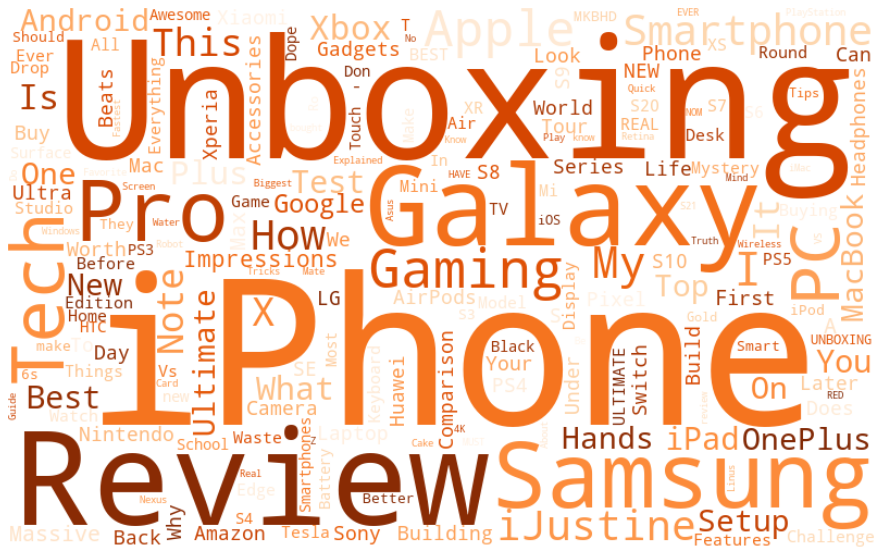

In [ ]:
# collapse

import texthero as herofrom

# Word cloud of top words from clean_title
herofrom.wordcloud(
    df.clean_title,
    max_words=200,
    #  contour_color='red',
    background_color="white",
    colormap="Oranges",
    height=500,
    width=800,
)


### Using Kmeans and PCA to Cluster of Video Titles 

__Note:__ Video titles fall into 5 topic groups.  
  * Iphone (kmeans 0)
  * Samsung (kmeans 1)
  * Reviews (kmeans 2)
  * Unboxing (kmeans 3)
  * How-to (kmeans 4)


In [ ]:
# collapse

# Add pca value to dataframe to use as visualization coordinates
df["pca"] = df["clean_title"].pipe(hero.tfidf).pipe(hero.pca)

# Add k-means cluster to dataframe
df["kmeans"] = df["clean_title"].pipe(hero.tfidf).pipe(hero.kmeans)

hero.scatterplot(df, "pca", color="kmeans", hover_data=["Video Title"])


### Correlations

__Note:__ The following seems to be highly correlated. 
* Channel Views and Subscribers 
* Interactions and Video Views

In [ ]:
#collapse
df.drop(columns=["Unnamed: 0","Width","Height"]).corr().style.background_gradient(
    subset=[
        "Channel Views (M)",
        "Subscribers (M)",
        "Video Views (M)",
        "Likes",
        "Video Comments",
        "Interactations (M)",
    ],
    cmap="Wistia",
)

,Channel Views (M),Subscribers (M),Video Views (M),Likes,Video Comments,Interactations (M)
Channel Views (M),1.000000,0.907635,0.586217,0.570409,0.138889,0.583878
Subscribers (M),0.907635,1.000000,0.659920,0.652701,0.163038,0.659026
Video Views (M),0.586217,0.659920,1.000000,0.708341,0.155869,0.996397
Likes,0.570409,0.652701,0.708341,1.000000,0.235680,0.715335
Video Comments,0.138889,0.163038,0.155869,0.235680,1.000000,0.156037
Interactations (M),0.583878,0.659026,0.996397,0.715335,0.156037,1.000000


## Take Aways 

1. Video Comment numbers have very little correlation to any data that was obtained in this project.

2. The following seem to be seems to be highly correlated. 
 * Channel Views and Subscribers
 * Interactions and Video Views

3. Video titles fall into 5 topic groups.  
  * Iphone (kmeans 0)
  * Samsung (kmeans 1)
  * Reviews (kmeans 2)
  * Unboxing (kmeans 3)
  * How-to (kmeans 4)

4. ___70%___ of the the most viewed videos are about phones.
5. the Join Date (Date a Youtube Channel was created) does not seem to have any relationship to number of subscribers or overall channel views.


## Resources

- [Top 25 Selenium Functions That Will Make You Pro In Web Scraping](https://towardsdatascience.com/top-25-selenium-functions-that-will-make-you-pro-in-web-scraping-5c937e027244)

- [How to build a Web Scraper or Bot in Python using Selenium](https://medium.com/daily-programming-tips/how-to-build-a-web-scraper-or-bot-in-python-using-selenium-2815f20023f7)

- [Web Scraping: Introduction, Best Practices & Caveats](https://medium.com/velotio-perspectives/web-scraping-introduction-best-practices-caveats-9cbf4acc8d0f)

- [Web Scraping Job Postings from Indeed.com using Selenium](https://towardsdatascience.com/web-scraping-job-postings-from-indeed-com-using-selenium-5ae58d155daf)


- [How I Use Selenium to Automate the Web With Python. Pt1 -  John Watson Rooney
](https://www.youtube.com/watch?v=pUUhvJvs-R4)